<a href="https://colab.research.google.com/github/elangbijak4/Riset-AI-Medis/blob/main/Training_Model_Deteksi_Foto_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opencv-python tensorflow

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
# Simulasi dua "sumber data"
def generate_fake_images(n, label, source_style='A'):
    images = []
    labels = []
    for _ in range(n):
        img = np.random.rand(64, 64) * 255

        if source_style == 'A':
            img = cv2.equalizeHist(img.astype(np.uint8))  # simulasi gaya A
        elif source_style == 'B':
            img = cv2.GaussianBlur(img.astype(np.uint8), (5, 5), 0)  # simulasi gaya B

        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Dataset A dan B (pneumonia = 1, non-pneumonia = 0)
images_A_pneu, labels_A_pneu = generate_fake_images(200, 1, 'A')
images_A_non, labels_A_non = generate_fake_images(200, 0, 'A')
images_B_pneu, labels_B_pneu = generate_fake_images(200, 1, 'B')
images_B_non, labels_B_non = generate_fake_images(200, 0, 'B')

# Gabung semua
images = np.concatenate([images_A_pneu, images_A_non, images_B_pneu, images_B_non], axis=0)
labels = np.concatenate([labels_A_pneu, labels_A_non, labels_B_pneu, labels_B_non], axis=0)

# Tambahkan dimensi channel dan normalisasi
images = images[..., np.newaxis] / 255.0

In [3]:
# Fungsi augmentasi: Gaussian Blur menggunakan OpenCV
def apply_gaussian_blur(images, kernel_size=(5, 5)):
    blurred = []
    for img in images:
        img_blur = cv2.GaussianBlur(img.squeeze(), kernel_size, 0)
        blurred.append(img_blur[..., np.newaxis])
    return np.array(blurred)

In [4]:
# Split awal: train-val-test (70%-15%-15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.15, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.18, stratify=y_trainval, random_state=42)

# Terapkan Gaussian blur pada data training saja
X_train_blur = apply_gaussian_blur(X_train)

In [5]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Klasifikasi biner
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
model = build_model()

history = model.fit(
    X_train_blur, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)

# Evaluasi pada data test (gambar tidak blur)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest Accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5433 - loss: 0.7039 - val_accuracy: 0.4959 - val_loss: 0.6945
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4889 - loss: 0.6942 - val_accuracy: 0.4959 - val_loss: 0.6933
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5081 - loss: 0.6929 - val_accuracy: 0.4959 - val_loss: 0.6935
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5070 - loss: 0.6932 - val_accuracy: 0.5041 - val_loss: 0.6930
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5115 - loss: 0.6932 - val_accuracy: 0.4959 - val_loss: 0.6933
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4532 - loss: 0.6934 - val_accuracy: 0.5041 - val_loss: 0.6935
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5091 - loss: 0.6931 - val_accuracy: 0.4959 - val_loss: 0.6942
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4937 - loss: 0.6931 - val_accuracy: 0.5041 - val_l

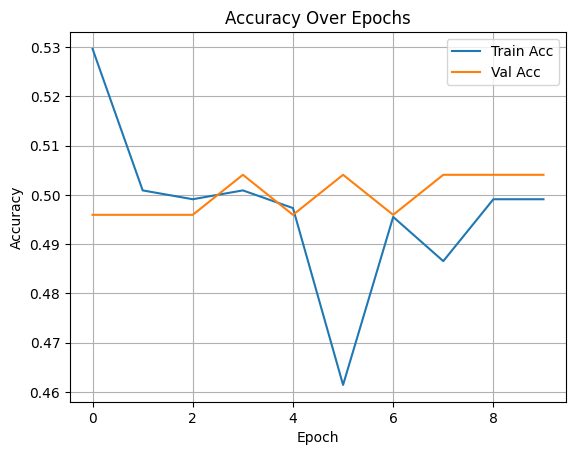

In [7]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

##Penjelasan Singkat:
1.   Dataset A dan B disimulasikan sebagai dua sumber dengan gaya berbeda
2.   Gaussian blur diterapkan hanya saat training untuk mensimulasikan kondisi dunia nyata
1.   CNN digunakan sebagai model dasar
2.   Evaluasi dilakukan pada gambar tidak blur, untuk menguji kemampuan generalisasi